#  Q-AGGREGATION

Define the Q-functional : 

\begin{align}
\begin{split}
Q(\theta) &= (1-\nu) R_n(f_\theta) &+ \nu \sum_{j=1} \theta_j R_n(f_j) \\
&= (1-\nu) \frac{1}{n} \sum_{i=1}^n (y_i - f_\theta(x_i))^2 &+ \nu \sum_{j=1}^M \theta_j \frac{1}{n} \sum_{i=1}^n (y_i - f_j(x_i))^2 \\
&= (1-\nu) \frac{1}{n} \sum_{i=1}^n (y_i - \sum_{j=1}^M \theta_j f_j(x_i))^2 &+ \nu \sum_{j=1}^M \theta_j \frac{1}{n} \sum_{i=1}^n (y_i - f_j(x_i))^2\end{split}
\end{align}

The Q-aggregate estimator verifies :

\begin{align}
\theta^Q \in \arg \min_{\theta \in \Theta} Q(\theta)
\end{align}


We can compute the partial derivatives of the Q-functional :

\begin{align}
\begin{split}
\frac{\partial}{\partial \theta_l} Q(\theta) &\propto (1-\nu) \sum_{i=1}^n -2 f_l(x_i) \left(y_i - \sum_{j=1}^M \lambda_j f_j(x_i)\right) + \nu \sum_{i=1}^n (y_i - f_l(x_i))^2 \\
&\propto \sum_{i=1}^n - 2 (1-\nu) f_l(x_i) \left(y_i - \sum_{j=1}^M \lambda_j f_j(x_i)\right) + \nu (y_i - f_l(x_i))^2
\end{split}
\end{align}

and use greedy Frank-Wolfe algorithm as in Rigollet et al.

We have shown that the performance of the algorithm deteriorates as we add outliers in the dataset.

We thus introduced a MOM version of the Q-functional :

\begin{align}
Q^{MOM}(\theta) = (1-\nu) MOM_K (f(\theta)) + \nu \sum_{j=1}^M \theta_j MOM_K(f(\theta_j)) 
\end{align}

We implemented a MOM version of the greedy Frank Wolfe algorithm (similar to the MOM version of gradient descent, i.e. at each step we randomly constitute blocks, we find the block which has the median mean and proceed to a normal step of the algorithm with the data from this median block). This does seem to work.

The next idea is to try IP methods to solve this problem. Greedy FW had the advantage of returning a sparse solution, however it seems that, since once a function is selected, it is neither removed, each step is "too" important.

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
%pylab inline

%load_ext autoreload
%autoreload 1

from Qagg import Q_aggregation
from test_functions import *
%aimport Qagg 
%aimport test_functions

Populating the interactive namespace from numpy and matplotlib


# Gaussian regression

We begin by consider a simple Gaussian regression model.

The model is defined by the following distributions :
\begin{align}
X \sim \mathcal{N}(0, I_d)\\
\xi \sim \mathcal{N}(0, \sigma^2) \\
Y = \langle X, t^* \rangle + \xi
\end{align}

In [2]:
# Example 
n_samples, d = 1000, 2
noise_sd = .5

# generate dataset
X, y = make_gaussian_regression(n_samples, d, noise_sd)

# split dataset in 3 datasets (train, aggregation, test)
X_train, X_agg, X_test, y_train, y_agg, y_test = train_agg_test_split(X, y, 0.4, 0.3)

# example of corruption
corruption_params = {'type':'constant', 'value':100}
X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers=0.3, corruption_params=corruption_params)

## Optimal rate of aggregation for Q-aggregation 

Lecué & Rigollet showed that the Q-aggregation procedure is optimal in the minimax sense for the model selection problem in the $L_\infty$ case when the error is measured w.r.t. the squared loss :

\begin{align}
R(f_\theta) \leq \min_{j=1, \dots, M}R(f_j) + C \frac{\log(M)}{n}
\end{align}

with $C$ an absolute constant. The inequality holds in expectation and with high-probability.

We want to check if the rate of convergence of the Q-aggregation procedure is indeed $\frac{1}{n}$ for the Gaussian regression case.

In order to do this we want to plot the regret $R(f_\theta) - \min_{j=1, \dots, M}R(f_j)$ as a fonction of the number of samples $n$.

Since the dependence we are looking for is exponential we want to change to log-scale to get a better feeling of what is happening : we will plot $\log(R(f_\theta))$ against $\log(n)$.

See the report fort more details about the way we proceeded

### i.i.d. case

In [3]:
# Expected risk estimation
d = 2
noise_sd = 1

n_Q_iterations = 5
n_train, n_test, n_datasets = 500, 3000, 500
logspace_num = 10

n_agg_array = np.logspace(1, 3, logspace_num, dtype=int)

# Generate random regression parameter
t = np.random.poisson(lam=0.5, size=d)

# Generate train dataset
X_train = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_train)
y_train = np.dot(X_train, t) + np.random.multivariate_normal(np.zeros(n_train), 
                                                             noise_sd**2*np.eye(n_train))

# Generate test dataset
X_test = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_test)
y_test = np.dot(X_test, t) + np.random.multivariate_normal(np.zeros(n_test), 
                                                           noise_sd**2*np.eye(n_test))

# Train predictors
predictors = make_function_class_regression()
q = Q_aggregation(predictors)
q.train_predictors(X_train, y_train)

# store empirical risks
r = np.zeros(n_datasets)
R = np.zeros(logspace_num)

compt = 0

for n_agg in tqdm(n_agg_array):
    for n in range(n_datasets):
        # Generate a dataset of n_agg observations
        X_agg = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_agg)
        y_agg = np.dot(X_agg, t) + np.random.multivariate_normal(np.zeros(n_agg), 
                                                                 noise_sd**2*np.eye(n_agg))
                
        # Compute the Q-aggregation weight vector
        theta = q.GMA_1(X_agg, y_agg, n_Q_iterations)
            
        # Compute the empirical risk
        r[n] = np.average((y_test - q.predict(X_test))**2)
    
    # store estimated risk
    R[compt] = np.average(r)
    compt +=1

KeyboardInterrupt: 

In [ ]:
# find minimum risk among dictionary
min_risk = np.min([np.average((y_test - predictor.predict(X_test))**2) 
                   for predictor in q.predictors ])

# compute excess risk
excess_risk = R - min_risk
excess_risk[excess_risk<=0] = 1e-9

from sklearn import linear_model
lr = linear_model.LinearRegression(fit_intercept=True)

lr.fit(X=np.log(n_agg_array).reshape(-1, 1), y=np.log(excess_risk))

plt.loglog(n_agg_array, excess_risk)
plt.xlabel('Number of samples for aggregation')
plt.ylabel('Estimated risk')

plt.loglog(n_agg_array, np.exp(lr.predict(np.log(n_agg_array).reshape(-1, 1))), alpha=0.3)

plt.legend(['Excess risk', 'Linear approximation (Slope = {:.2f})'.format(lr.coef_[0])])

plt.savefig('Estimated_risk_5.pdf', dpi=400)

### Distribution of the weights

In [207]:
n_runs = 50

# Expected risk estimation
d = 200
noise_sd = 1

n_Q_iterations = 5
n_train, n_agg = 500, 500

# Generate random regression parameter
t = np.random.poisson(lam=0.1, size=d)

# Generate train dataset
X_train = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_train)
y_train = np.dot(X_train, t) + np.random.multivariate_normal(np.zeros(n_train), noise_sd**2*np.eye(n_train))

# Train predictors
predictors = make_function_class_regression()
q = Q_aggregation(predictors)
q.train_predictors(X_train, y_train)

weight_distribution = np.zeros((len(predictors), n_runs))

for n in tqdm(range(n_runs)):

    # Generate a dataset of n_agg observations
    X_agg = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_agg)
    y_agg = np.dot(X_agg, t) + np.random.multivariate_normal(np.zeros(n_agg), noise_sd**2*np.eye(n_agg))
        
    theta = q.GMA_1(X_agg, y_agg, n_Q_iterations)
    weight_distribution[:, n] = theta

100%|██████████| 50/50 [01:49<00:00,  2.19s/it]


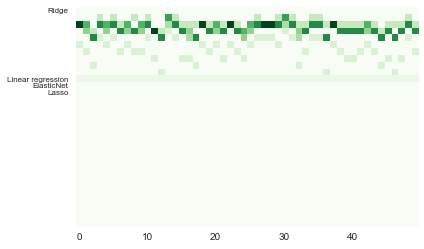

In [208]:
plt.imshow(weight_distribution, cmap='Greens')
plt.grid(False)
plt.yticks([0, 10, 11, 12], ['Ridge', 'Linear regression', 'ElasticNet', 'Lasso'], fontsize = 8)
plt.tight_layout()
#plt.savefig('d={}_sparser.pdf'.format(str(d)), dpi=400)

### Corrupted data

In [220]:
# Expected risk estimation
d = 2
noise_sd = 1

n_Q_iterations = 5
n_train, n_test, n_datasets = 500, 2000, 50
logspace_num = 10

n_agg_array = np.logspace(1, 3, logspace_num, dtype=int)

# Generate random regression parameter
t = np.random.poisson(lam=0.5, size=d)

# Generate train dataset
X_train = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_train)
y_train = np.dot(X_train, t) + np.random.multivariate_normal(np.zeros(n_train), 
                                                             noise_sd**2*np.eye(n_train))

# Generate test dataset
X_test = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_test)
y_test = np.dot(X_test, t) + np.random.multivariate_normal(np.zeros(n_test), 
                                                           noise_sd**2*np.eye(n_test))

# Train predictors
predictors = make_function_class_regression()
q = Q_aggregation(predictors)
q.train_predictors(X_train, y_train)

# store empirical risks
r = np.zeros(n_datasets)
R = np.zeros(logspace_num)

compt = 0

# Outlier parameters
prop_outliers = 0.05
corruption_params = {'type':'constant', 'value': 100}


for n_agg in tqdm(n_agg_array):
    for n in range(n_datasets):
        # Generate a dataset of n_agg observations
        X_agg = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_agg)
        y_agg = np.dot(X_agg, t) + np.random.multivariate_normal(np.zeros(n_agg), 
                                                                 noise_sd**2*np.eye(n_agg))
                
        X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers, corruption_params)
        # Compute the Q-aggregation weight vector
        theta = q.GMA_1(X_agg, y_agg, n_Q_iterations)
            
        # Compute the empirical risk
        r[n] = np.average((y_test - q.predict(X_test))**2)
    
    # store estimated risk
    R[compt] = np.average(r)
    compt +=1

100%|██████████| 10/10 [08:01<00:00, 48.18s/it]


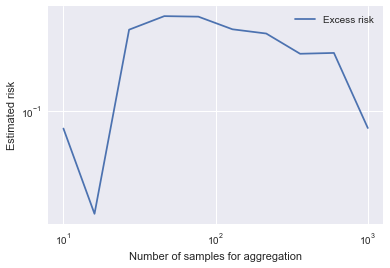

In [222]:
# find minimum risk among dictionary
min_risk = np.min([np.average((y_test - predictor.predict(X_test))**2) 
                   for predictor in q.predictors ])

# compute excess risk
excess_risk = R - min_risk
excess_risk[excess_risk<=0] = 1e-9

from sklearn import linear_model
lr = linear_model.LinearRegression(fit_intercept=True)

lr.fit(X=np.log(n_agg_array).reshape(-1, 1), y=np.log(excess_risk))

plt.loglog(n_agg_array, excess_risk)
plt.xlabel('Number of samples for aggregation')
plt.ylabel('Estimated risk')

#plt.loglog(n_agg_array, np.exp(lr.predict(np.log(n_agg_array).reshape(-1, 1))), alpha=0.3)

plt.legend(['Excess risk', 'Linear approximation (Slope = {:.2f})'.format(lr.coef_[0])])

plt.savefig('Estimated_risk_outliers.pdf', dpi=400)

Introducing outliers, even a proportion as small as $5\%$ seems to completely break down the statistical properties of the Q-aggregation procedure. It is time to try the MOM version of Q-aggregation !

### MOM-version

In [10]:
# -0.7
#n_blocks = np.array([5, 4, 5, 8, 8, 12, 15, 20, 30, 50])

# - 0.5
#n_blocks = np.array([5, 4, 5, 8, 8, 12, 15, 20, 50, 60])

# - 0.7
#n_blocks = np.array([5, 4, 5, 8, 8, 12, 15, 20, 20, 30])

# - 0.78
#n_blocks = np.array([5, 4, 5, 8, 8, 12, 20, 20, 20, 30])

# - 0.93
#n_blocks = np.array([5, 4, 5, 8, 20, 20, 20, 20, 20, 30])

# -0.7
#n_blocks = np.array([5, 4, 5, 8, 15, 20, 20, 20, 20, 30])


# Corrupted
n_blocks = np.array([5, 8, 8, 8, 15, 25, 30, 50, 60, 100])

In [11]:
# Expected risk estimation
d = 2
noise_sd = 1

n_Q_iterations = 5
n_train, n_test, n_datasets = 500, 2000, 500
logspace_num = 10

n_agg_array = np.logspace(1, 3, logspace_num, dtype=int)

# Generate random regression parameter
t = np.random.poisson(lam=0.5, size=d)

# Generate train dataset
X_train = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_train)
y_train = np.dot(X_train, t) + np.random.multivariate_normal(np.zeros(n_train), noise_sd**2*np.eye(n_train))

# Generate test dataset
X_test = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_test)
y_test = np.dot(X_test, t) + np.random.multivariate_normal(np.zeros(n_test), noise_sd**2*np.eye(n_test))

# Train predictors
predictors = make_function_class_regression()
q = Q_aggregation(predictors)
q.train_predictors(X_train, y_train)

# store empirical risks
R = np.zeros(logspace_num)

compt = 0

best_n_blocks = np.zeros(logspace_num)

# Outlier parameters
prop_outliers = 0.05
corruption_params = {'type':'constant', 'value':100}

for n_agg in tqdm(n_agg_array):
    r = 10*np.ones(n_datasets)
    for n in range(n_datasets):
        # Generate a dataset of n_agg observations
        X_agg = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_agg)
        y_agg = np.dot(X_agg, t) + np.random.multivariate_normal(np.zeros(n_agg), noise_sd**2*np.eye(n_agg))
        
        X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers, corruption_params)
        
        #for n_blocks in np.linspace(2, n_agg/2, 20, dtype=int):
        #    # Compute the Q-aggregation weight vector
        #    theta = q.GMA_1_MOM(X_agg, y_agg, n_Q_iterations, n_blocks)
        #    
        #    est_risk = np.average((y_test - q.predict(X_test))**2)
        #    
        #    if est_risk < r[n]:
        #        # Compute the empirical risk
        #        r[n] = est_risk
        
        theta = q.GMA_1_MOM(X_agg, y_agg, n_Q_iterations, n_blocks[compt])
        #q.GMA_1(X_agg, y_agg, n_Q_iterations)
        r[n] = np.average((y_test - q.predict(X_test))**2)
        
    # store estimated risk
    R[compt] = np.average(r)
    compt +=1

100%|██████████| 10/10 [42:01<00:00, 252.17s/it]


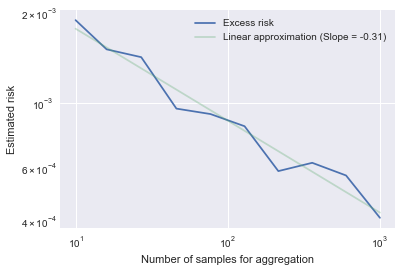

In [12]:
# find minimum risk among dictionary
min_risk = np.min([np.average((y_test - predictor.predict(X_test))**2) 
                   for predictor in q.predictors ])

# compute excess risk
excess_risk = R - min_risk
excess_risk[excess_risk<=0] = 1e-16

from sklearn import linear_model
lr = linear_model.LinearRegression(fit_intercept=True)

lr.fit(X=np.log(n_agg_array).reshape(-1, 1), y=np.log(excess_risk))

plt.loglog(n_agg_array, excess_risk)
plt.xlabel('Number of samples for aggregation')
plt.ylabel('Estimated risk')

plt.loglog(n_agg_array, np.exp(lr.predict(np.log(n_agg_array).reshape(-1, 1))), alpha=0.3)

plt.legend(['Excess risk', 'Linear approximation (Slope = {:.2f})'.format(lr.coef_[0])])

#plt.savefig('Estimated_risk_MOM_corrupted.pdf', dpi=400)

## 1st type of corruption : constant value target

A determined proportion of the samples'target are set to the same value.


- How does the distribution of the regret (and the mean regret) behave as a function of the proportion of outliers, the outlier target value behind fixed ? Does varying the number of blocks for the MOM method change anything ?
- How does the mean regret behave as a function of the outlier target value the proportion of outliers being fixed for GMA-1 and MOM-GMA-1 ?

In [ ]:
corruption_params = {'type':'constant', 'value':1e9}
agg_params={'method':'GMA_1', 'nb_iterations':5}
GMA_1_regret = test_gaussian_regression_outliers(n_samples=1000, d=20, n_replications=50, 
                                        prop_outliers=.3, corruption_params=corruption_params,
                                                 agg_params=agg_params, noise_sd=noise_sd)

In [32]:
agg_params={'method':'GMA_1_MOM', 'nb_iterations':10, 'nb_blocks':30}
GMA_1_MOM_regret = test_gaussian_regression_outliers(n_samples=1000, d=20, n_replications=10, 
                                      prop_outliers=.3, corruption_params=corruption_params, 
                                                     agg_params=agg_params, noise_sd=noise_sd)


 30%|███       | 3/10 [00:06<00:15,  2.20s/it]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/Users/Schreuder/anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/Schreuder/anaconda/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Schreuder/anaconda/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


In [62]:
corrupted_target_values = np.logspace(0, 7, num=8)
mean_regret_constant_target = []
for corrupted_target_value in corrupted_target_values:
    corruption_params = {'type':'constant', 'value':corrupted_target_value}
    agg_params={'method':'GMA_1', 'nb_iterations':5}
    GMA_1_regret = test_gaussian_regression_outliers(n_samples=1000, d=10, n_replications=50, 
                                            prop_outliers=.3, corruption_params=corruption_params,
                                                     agg_params=agg_params, noise_sd=noise_sd)
    mean_regret_constant_target.append(np.mean(GMA_1_regret))


  0%|          | 0/50 [00:00<?, ?it/s]
Exception in thread Thread-31:
Traceback (most recent call last):
  File "/Users/Schreuder/anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/Schreuder/anaconda/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Schreuder/anaconda/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


In [64]:
mean_regret_constant_target_MOM = []
for corrupted_target_value in corrupted_target_values:
    corruption_params = {'type':'constant', 'value':corrupted_target_value}
    agg_params={'method':'GMA_1_MOM', 'nb_iterations':5, 'nb_blocks':50}
    GMA_1_MOM_regret = test_gaussian_regression_outliers(n_samples=1000, d=10, n_replications=50, 
                                      prop_outliers=.3, corruption_params=corruption_params, 
                                                     agg_params=agg_params, noise_sd=noise_sd)
    mean_regret_constant_target_MOM.append(np.mean(GMA_1_MOM_regret))


  8%|▊         | 4/50 [00:05<00:57,  1.26s/it]
Exception in thread Thread-42:
Traceback (most recent call last):
  File "/Users/Schreuder/anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/Schreuder/anaconda/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Schreuder/anaconda/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


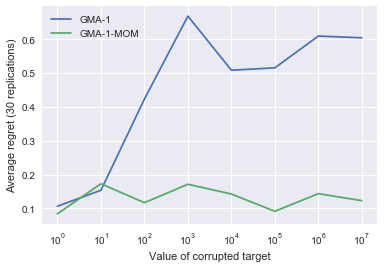

In [65]:
plt.semilogx(corrupted_target_values, mean_regret_constant_target)
plt.semilogx(corrupted_target_values, mean_regret_constant_target_MOM)
plt.legend(['GMA-1','GMA-1-MOM'])
plt.xlabel('Value of corrupted target')
plt.ylabel('Average regret (30 replications)')

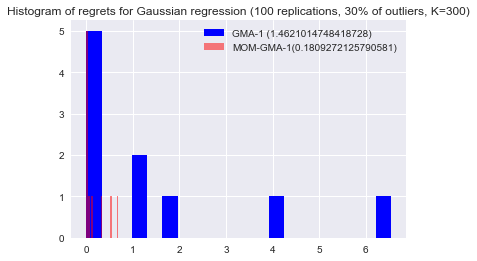

In [33]:
plt.hist(GMA_1_regret, color='blue', bins=20)
plt.hist(GMA_1_MOM_regret, color='red', bins=20, alpha=.5)
plt.legend(['GMA-1 ({})'.format(np.mean(np.array(GMA_1_regret))), 'MOM-GMA-1({})'.format(np.mean(np.array(GMA_1_MOM_regret)))])
plt.title('Histogram of regrets for Gaussian regression (100 replications, 30% of outliers, K=300)')
plt.savefig('rep_100_prop_30_K_300.jpg', bbox_inches='tight')

# Plots

In [13]:
outliers_props = np.linspace(0, 1, 5)
n_replications = 100

GMA_1_regrets = np.zeros((n_replications, len(outliers_props)))
for j, prop_outliers in enumerate(outliers_props):
    GMA_1_regrets[:,j] = test_gaussian_regression_outliers(n_samples=1000, d=20, n_replications=n_replications, 
                                      prop_outliers=prop_outliers, agg_method='GMA_1', noise_sd=noise_sd)

100%|██████████| 100/100 [05:50<00:00,  3.50s/it]


In [56]:
outliers_props = np.linspace(0, 1, 5)
n_replications = 100

GMA_1_MOM_regrets = np.zeros((n_replications, len(outliers_props)))
for j, prop_outliers in enumerate(outliers_props):
    GMA_1_MOM_regrets[:,j] = test_gaussian_regression_outliers(n_samples=1000, d=20, n_replications=n_replications, 
                                      prop_outliers=prop_outliers, agg_method='GMA_1_MOM', noise_sd=noise_sd)

100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


In [57]:
outliers_props

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

(array([6., 3., 6., 8., 7., 6., 8., 6., 2., 6., 5., 3., 3., 4., 3., 4., 1.,
        3., 1., 3., 1., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.        , 0.0875558 , 0.17511159, 0.26266739, 0.35022318,
        0.43777898, 0.52533478, 0.61289057, 0.70044637, 0.78800216,
        0.87555796, 0.96311375, 1.05066955, 1.13822535, 1.22578114,
        1.31333694, 1.40089273, 1.48844853, 1.57600433, 1.66356012,
        1.75111592, 1.83867171, 1.92622751, 2.01378331, 2.1013391 ,
        2.1888949 , 2.27645069, 2.36400649, 2.45156229, 2.53911808,
        2.62667388, 2.71422967, 2.80178547, 2.88934126, 2.97689706,
        3.06445286, 3.15200865, 3.23956445, 3.32712024, 3.41467604,
        3.50223184, 3.58978763, 3.67734343, 3.76489922, 3.85245502,
        3.94001082, 4.02756661, 4.11512241, 4.2026782 , 4.290234  ,
        4.37778979]),
 <a list of 50 Patch objects>)

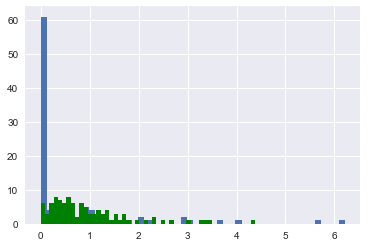

In [61]:
plt.hist(GMA_1_regrets[:,1], bins=50)
plt.hist(GMA_1_MOM_regrets[:,1], color='green', bins=50)

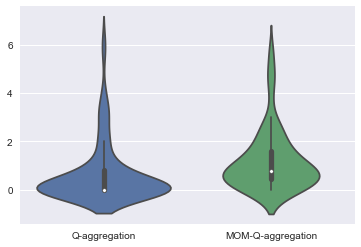

In [55]:
regrets_array = np.array([GMA_1_regrets[:,1], GMA_1_MOM_regrets[:,1]]).T
df = pd.DataFrame(regrets_array) 
df.columns = ["Q-aggregation", "MOM-Q-aggregation"]

ax = sns.violinplot(data=df, shape='count')
#ax.hlines(fast_residual_term, *ax.get_xlim(), alpha=0.7, color='black', linestyle='dashed', label='Optimal regret')

In [14]:
ax = sns.violinplot(df, scale='count')
ax.set(yscale="log")
#ax.set_ylim(0, 5)
ax.hlines(fast_residual_term, *ax.get_xlim(), alpha=0.7, color='black', linestyle='dashed', label='Optimal regret')
plt.legend()
plt.title('Distributions of the regret for Q-aggregation')
plt.xlabel('Proportion of outliers')
plt.ylabel('Regret (log-scale)')

NameError: name 'sns' is not defined

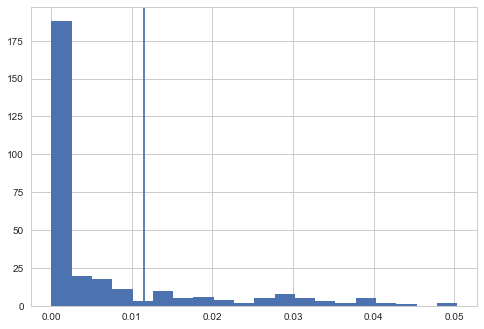

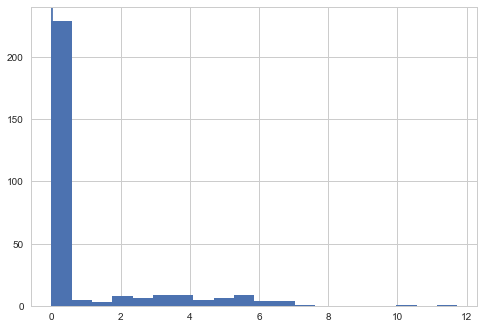

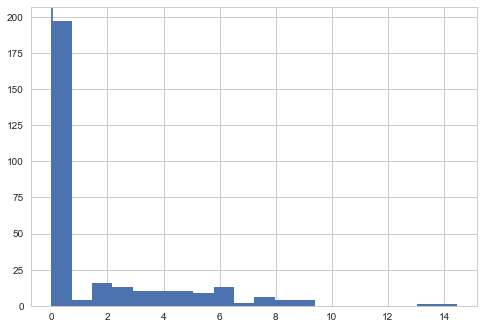

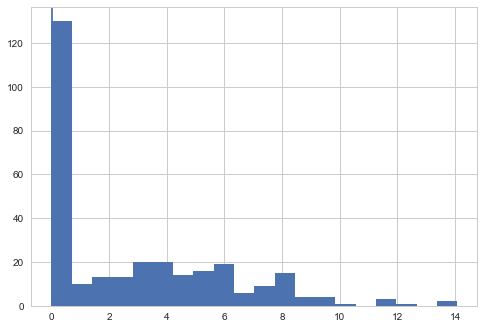

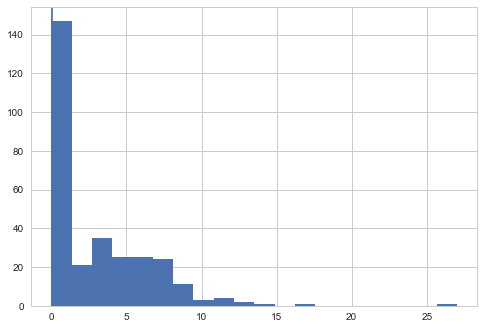

In [438]:
for i in range(5):
    plt.hist(regrets[:,i], bins=20)
    plt.axvline(fast_residual_term)
    plt.show()

# MOM version

In [13]:
# find median index
data = [0, 5, 3, 6, 23, 15, 19, 20, 19, 21]
data[numpy.argsort(data)[len(data)//2]]

19

In [34]:
regrets_MOM = []

n_replicate = 10

for i in tqdm(range(n_replicate)):
    X, y = make_gaussian_regression(n_samples, d, noise_sd)

    X_train, X_agg, X_test, y_train, y_agg, y_test = train_agg_test_split(X, y, 0.4, 0.3)

    predictors = make_function_class_regression()

    q = Q_aggregation(predictors)

    q.train_predictors(X_train, y_train)

    X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers=.25, corruption_type='constant')

    q.GMA_1_MOM(X_agg, y_agg, 30, 10)

    MSE_agg = mean_squared_error(q.predict(X_test), y_test)

    oracle_agg = np.min([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    worst_agg = np.max([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    regrets_MOM.append(MSE_agg - oracle_agg)

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


In [20]:
regrets = []
for i in tqdm(range(n_replicate)):
    X, y = make_gaussian_regression(n_samples, d, noise_sd)

    X_train, X_agg, X_test, y_train, y_agg, y_test = train_agg_test_split(X, y, 0.4, 0.3)

    predictors = make_function_class_regression()

    q = Q_aggregation(predictors)

    q.train_predictors(X_train, y_train)

    X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers=.25, corruption_type='constant')

    q.GMA_1(X_agg, y_agg, 30)

    MSE_agg = mean_squared_error(q.predict(X_test), y_test)

    oracle_agg = np.min([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    worst_agg = np.max([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    regrets.append(MSE_agg - oracle_agg)

100%|██████████| 300/300 [40:21<00:00,  8.07s/it]


In [27]:
regrets_array = np.array([regrets, regrets_MOM]).T
df_2 = pd.DataFrame(regrets_array) 
df_2.columns = ["Q-aggregation", "MOM-Q-aggregation"]

ax = sns.violinplot(data=df_2, shape='count')
ax.hlines(fast_residual_term, *ax.get_xlim(), alpha=0.7, color='black', linestyle='dashed', label='Optimal regret')

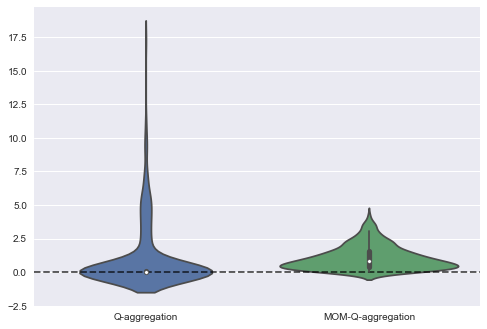

In [32]:
ax = sns.violinplot(data=df_2, shape='count')
ax.hlines(fast_residual_term, *ax.get_xlim(), alpha=0.7, color='black', linestyle='dashed', label='Optimal regret')

In [29]:
fast_residual_term = np.log(len(predictors))/y_agg.shape[0]
fast_residual_term

0.011552453009332421